# 0. Getting Started

In [1]:
# Standard PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets




# Standard library for mathematical functions
import numpy as np

# OS module and Path libraries
import os
from pathlib import Path

In [2]:
# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.0+cu118'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Dataset Setup

In [4]:
# Connect Google Drive to a Google Colab Notebook for Dataset
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
required_classes_list = ["A041", "A042", "A043", "A044", "A045", "A046", "A047", "A048", "A049", "A103", "A104", "A105"]

In [6]:
# creates a Path object called "drive_path" with the path "/content/gdrive/"
drive_path = Path('/content/gdrive/')

# creates a Path object called "dataset_path_in_drive"
dataset_path_in_drive = Path('/content/gdrive/MyDrive/MyColabFiles/MyColabFiles') / 'dataset'

print(dataset_path_in_drive)

/content/gdrive/MyDrive/MyColabFiles/MyColabFiles/dataset


In [7]:
# Setup train and testing paths
train_dir = dataset_path_in_drive / "train"
test_dir = dataset_path_in_drive / "test"

print("Training Dataset Path: {}\nTesting Dataset Path: {}".format(train_dir, test_dir))

Training Dataset Path: /content/gdrive/MyDrive/MyColabFiles/MyColabFiles/dataset/train
Testing Dataset Path: /content/gdrive/MyDrive/MyColabFiles/MyColabFiles/dataset/test


In [22]:
# Takes in a file path and loads a NumPy array
def npy_loader(path):
    data = np.load(path ,allow_pickle=True).item()["skel_body0"][:, :20]
    if data.shape[0] >= 30:
        return data[:30]
    # else:
    #     return None

In [23]:
train_data = datasets.DatasetFolder(root=train_dir, # target folder of skeletons
                                    loader=npy_loader,
                                    extensions=['.npy'],
                                    target_transform=None) # transforms to perform on labels (if necessary)

In [24]:
len(train_data)

2248

In [25]:
train_data[1000]

(array([[[-1.632375e-01, -2.719418e-01,  3.793614e+00],
         [-1.610523e-01,  4.210661e-02,  3.846833e+00],
         [-1.581150e-01,  3.500930e-01,  3.886799e+00],
         ...,
         [-1.258912e-02, -6.452508e-01,  3.676026e+00],
         [ 5.057659e-02, -9.741414e-01,  3.607743e+00],
         [-5.858317e-04, -9.986490e-01,  3.480269e+00]],
 
        [[-1.623635e-01, -2.719830e-01,  3.793427e+00],
         [-1.605287e-01,  4.207006e-02,  3.846594e+00],
         [-1.578705e-01,  3.500673e-01,  3.886553e+00],
         ...,
         [-1.237373e-02, -6.445345e-01,  3.676000e+00],
         [ 5.025174e-02, -9.735253e-01,  3.607689e+00],
         [-7.577874e-04, -9.980372e-01,  3.480130e+00]],
 
        [[-1.615281e-01, -2.718283e-01,  3.795125e+00],
         [-1.601908e-01,  4.162662e-02,  3.847232e+00],
         [-1.577816e-01,  3.489477e-01,  3.886734e+00],
         ...,
         [-1.206885e-02, -6.445941e-01,  3.675985e+00],
         [ 5.155781e-02, -9.734418e-01,  3.607960e+00],


In [26]:
video_no_1000_data, _label = train_data[1000]

In [27]:
print(video_no_1000_data.shape, _label)

(30, 20, 3) 1


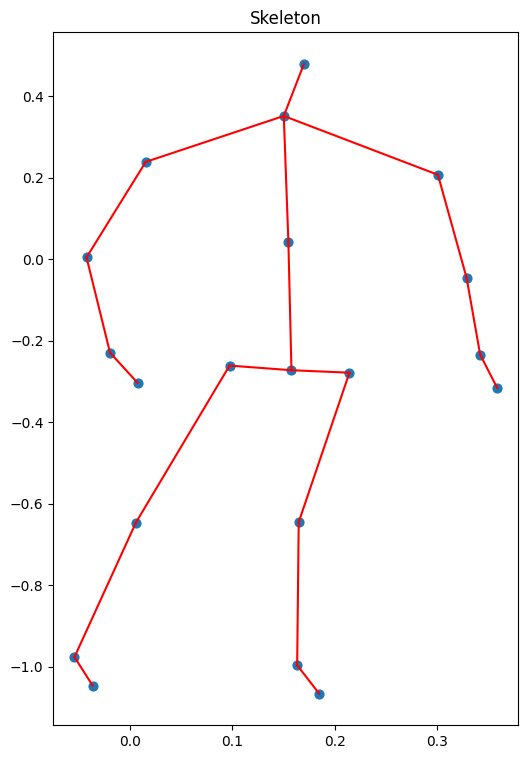

In [28]:
# Drawing frame no. 10 of 50th video from training dataset for sample 
import matplotlib.pyplot as plt
import numpy as np


movement = np.array(video_no_1000_data[10]*-1)

bone_list = [[1, 2], [1, 17], [1, 13], [17, 18], [18, 19], [19, 20], [13, 14],
            [14, 15], [15, 16], [2, 3], [3, 9], [3, 5], [3, 4],
            [5, 6], [9, 10], [10, 11], [11, 12], [6, 7], [7, 8]]

bone_list = np.array(bone_list) - 1
number_of_postures = int(len(movement)/20)

for i in range(number_of_postures):
    fig, ax = plt.subplots(1, figsize=(6, 9))
    plt.title('Skeleton')
    skeleton = movement[i*20:(i+1)*20]

    x = skeleton[:, 0]
    y = -skeleton[:, 1]

    sc = ax.scatter(x, y, s=40)
    for bone in bone_list:
        ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], 'r')
  

In [31]:
def loadSequentialDATASET(batchSize=1):
  """
  Loads and preprocesses sequential data from files in train_dir and test_dir using the "npy_loader" function.
  Returns two PyTorch DataLoaders for the training and testing sets, respectively.

  Parameters:
    - batchSize (int): Number of samples per batch (default: 1).

  Returns:
    - train_dataloader (DataLoader): PyTorch DataLoader object for the training set.
    - test_dataloader (DataLoader): PyTorch DataLoader object for the testing set.
    
    - remove_videos_with_less_than_30_frames (boolean): If True, videos that have less than 30 frames will be removed from the dataset.
    
    - num_videos (int): The number of videos in the dataset.
  """

  # Creates PyTorch dataset from train_dir.
  train_data = datasets.DatasetFolder(root=train_dir, # target folder of skeletons
                                    loader=npy_loader,
                                    extensions=['.npy'],
                                    target_transform=None) # transforms to perform on labels (if necessary)

  # Creates PyTorch dataset from test_dir.
  test_data = datasets.DatasetFolder(root=test_dir,
                                    loader=npy_loader,
                                    extensions=['.npy'])
    
  print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

  # Remove videos that have less than 30 frames
  # if remove_videos_with_less_than_30_frames:
  # train_data = [d for d in train_data if d is not None]
  # test_data = [d for d in test_data if d is not None]

  # Turn train and test Datasets into DataLoaders
  train_dataloader = DataLoader(dataset=train_data, 
                                batch_size=batchSize, # how many samples per batch?
                                num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                                shuffle=True) # shuffle the data?

  test_dataloader = DataLoader(dataset=test_data, 
                                batch_size=batchSize, 
                                num_workers=1, 
                                shuffle=False) # don't usually need to shuffle testing data

  # Count the number of videos in the dataset
  num_videos = len(train_data) + len(test_data)
  print(num_videos)


  return train_dataloader, test_dataloader


# 2. Building a model(IndRNN)

In [32]:
import torch
from torch.nn import Parameter
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math


class IndRNNCell(nn.Module):
    r"""An IndRNN cell with tanh or ReLU non-linearity.
    .. math::
        h' = \tanh(w_{ih} * x + b_{ih}  +  w_{hh} (*) h)
    With (*) being element-wise vector multiplication.
    If nonlinearity='relu', then ReLU is used in place of tanh.
    Args:
        input_size: The number of expected features in the input x
        hidden_size: The number of features in the hidden state h
        bias: If ``False``, then the layer does not use bias weights b_ih and b_hh.
            Default: ``True``
        nonlinearity: The non-linearity to use ['tanh'|'relu']. Default: 'relu'
        hidden_min_abs: Minimal absolute inital value for hidden weights. Default: 0
        hidden_max_abs: Maximal absolute inital value for hidden weights. Default: None
    Inputs: input, hidden
        - **input** (batch, input_size): tensor containing input features
        - **hidden** (batch, hidden_size): tensor containing the initial hidden
          state for each element in the batch.
    Outputs: h'
        - **h'** (batch, hidden_size): tensor containing the next hidden state
          for each element in the batch
    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(input_size x hidden_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
    Examples::
        >>> rnn = nn.IndRNNCell(10, 20)
        >>> input = Variable(torch.randn(6, 3, 10))
        >>> hx = Variable(torch.randn(3, 20))
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="relu",
                 hidden_min_abs=0, hidden_max_abs=None):
        super(IndRNNCell, self).__init__()
        self.hidden_max_abs = hidden_max_abs
        self.hidden_min_abs = hidden_min_abs
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        self.weight_ih = Parameter(torch.Tensor(hidden_size, input_size))
        self.weight_hh = Parameter(torch.Tensor(hidden_size))
        if bias:
            self.bias_ih = Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias_ih', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for name, weight in self.named_parameters():
            if "bias" in name:
                weight.data.zero_()
            elif "weight_hh" in name:
                if self.hidden_max_abs:
                    stdv_ = self.hidden_max_abs
                else:
                    stdv_ = stdv
                weight.data.uniform_(-stdv_, stdv_)
            elif "weight_ih" in name:
                weight.data.normal_(0, 0.01)
            else:
                weight.data.normal_(0, 0.01)
                # weight.data.uniform_(-stdv, stdv)
        self.check_bounds()

    def check_bounds(self):
        if self.hidden_min_abs:
            abs_kernel = torch.abs(self.weight_hh.data)
            min_abs_kernel = torch.clamp(abs_kernel, min=self.hidden_min_abs)
            self.weight_hh.data.copy_(
                torch.mul(torch.sign(self.weight_hh.data), min_abs_kernel))
        if self.hidden_max_abs:
            self.weight_hh.data.copy_(
                torch.clamp(self.weight_hh.data, max=self.hidden_max_abs,
                            min=-self.hidden_max_abs))

    def forward(self, input, hx):
        if self.nonlinearity == "tanh":
            func = IndRNNTanhCell
        elif self.nonlinearity == "relu":
            func = IndRNNReLuCell
        else:
            raise RuntimeError(
                "Unknown nonlinearity: {}".format(self.nonlinearity))

        return func(input, hx, self.weight_ih, self.weight_hh, self.bias_ih)


def IndRNNTanhCell(input, hidden, w_ih, w_hh, b_ih=None):
    hy = F.tanh(F.linear(input, w_ih, b_ih) + F.mul(w_hh, hidden))
    return hy


def IndRNNReLuCell(input, hidden, w_ih, w_hh, b_ih=None):
    # hy = F.relu(F.linear(input, w_ih, b_ih) + F.mul(w_hh, hidden))
    # print(input.dtype)
    # print(hidden.dtype)
    # print(w_ih.dtype)
    # print(w_hh.dtype)
    # print(b_ih.dtype)


    hy = F.relu(F.linear(input, w_ih, b_ih) + torch.mul(w_hh, hidden))
    return hy


class IndRNN(nn.Module):
    r"""Applies a multi-layer IndRNN with `tanh` or `ReLU` non-linearity to an
    input sequence.
    For each element in the input sequence, each layer computes the following
    function:
    .. math::
        h_t = \tanh(w_{ih} x_t + b_{ih}  +  w_{hh} (*) h_{(t-1)})
    where :math:`h_t` is the hidden state at time `t`, and :math:`x_t` is
    the hidden state of the previous layer at time `t` or :math:`input_t`
    for the first layer. (*) is element-wise multiplication.
    If :attr:`nonlinearity`='relu', then `ReLU` is used instead of `tanh`.
    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers.
        nonlinearity: The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as `(batch, seq, feature)`
    Inputs: input, h_0
        - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
          of the input sequence. The input can also be a packed variable length
          sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
          or :func:`torch.nn.utils.rnn.pack_sequence`
          for details.
        - **h_0** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
          containing the initial hidden state for each element in the batch.
          Defaults to zero if not provided.
    Outputs: output, h_n
        - **output** of shape `(seq_len, batch, hidden_size * num_directions)`: tensor
          containing the output features (`h_k`) from the last layer of the RNN,
          for each `k`.  If a :class:`torch.nn.utils.rnn.PackedSequence` has
          been given as the input, the output will also be a packed sequence.
        - **h_n** (num_layers * num_directions, batch, hidden_size): tensor
          containing the hidden state for `k = seq_len`.
    Attributes:
        cells[k]: individual IndRNNCells containing the weights
    Examples::
        >>> rnn = nn.IndRNN(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> output = rnn(input, h0)
    """

    def __init__(self, input_size, hidden_size, n_layer=1, batch_norm=False,
                 step_size=None, **kwargs):
        super(IndRNN, self).__init__()
        self.hidden_size = hidden_size
        if batch_norm and step_size is None:
            raise Exception("Frame wise batch size needs to know the step size")
        self.batch_norm = batch_norm
        self.step_size = step_size
        self.n_layer = n_layer

        cells = []
        for i in range(n_layer):
            if i == 0:
                cells += [IndRNNCell(input_size, hidden_size, **kwargs)]
            else:
                cells += [IndRNNCell(hidden_size, hidden_size, **kwargs)]
        self.cells = nn.ModuleList(cells)

        if batch_norm:
            bns = []
            for i in range(n_layer):
                bns += [nn.BatchNorm2d(step_size)]
            self.bns = nn.ModuleList(bns)

        h0 = torch.zeros(hidden_size)
        self.register_buffer('h0', torch.autograd.Variable(h0))

    def forward(self, x, hidden=None):

        for i, cell in enumerate(self.cells):
            cell.check_bounds()
            hx = self.h0.unsqueeze(0).expand(x.size(0), self.hidden_size).contiguous()
            outputs = []
            for t in range(x.size(1)):
                x_t = x[:, t]
                hx = cell(x_t, hx)
                outputs += [hx]
            x = torch.stack(outputs, 1)
            if self.batch_norm:
                x = self.bns[i](x)
        return x.squeeze(2)

In [33]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

torch.manual_seed(1)


class BaseModel(nn.Module):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell):

        super(BaseModel, self).__init__()
        self.hiddenNum = hiddenNum
        self.inputDim = inputDim
        self.outputDim = outputDim
        self.layerNum = layerNum

        if cell == "INDRNN":
            self.cell = IndRNN(input_size=self.inputDim, hidden_size=self.hiddenNum, n_layer= self.layerNum)
        print("cell type:", self.cell)
        self.fc = nn.Linear(self.hiddenNum, self.outputDim)


class IndRNNModel(BaseModel):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum):
        super(IndRNNModel, self).__init__(inputDim, hiddenNum, outputDim, layerNum, cell="INDRNN")

    def forward(self, x, batchSize):

        #h0 = torch.zeros(self.layerNum*1, batchSize, 28)

        rnnOutput = self.cell(x,)

        rnnOutput = rnnOutput[:, -1, :].squeeze()

        out = self.fc(rnnOutput)
        # out = F.log_softmax(out)
        out = F.log_softmax(out, dim=1)


        return out

In [35]:
import matplotlib.pyplot as plt

epoch = 100
batchSize = 128
model = IndRNNModel(inputDim=60, hiddenNum=256, outputDim=3, layerNum=3)
useCuda=True

if useCuda:
    model = model.cuda()

checkPoint = 10

optimizer = optim.Adam(model.parameters(), lr=0.01, )
ceriation = nn.NLLLoss()
trainLoader, testLoader = loadSequentialDATASET(batchSize=batchSize)

train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, epoch + 1):

    # trainning
    sum_loss = 0
    model.train()

    for batch_idx, (x, target) in enumerate(trainLoader):

        optimizer.zero_grad()
        if useCuda:
            x = x.view(-1, 30, 60)
            x, target = x.cuda().float(), target.cuda()

        out = model(x, batchSize)
        loss = ceriation(out, target)
        sum_loss += loss.item()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % checkPoint == 0 or (batch_idx + 1) == len(trainLoader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format( i, batch_idx + 1, sum_loss/checkPoint))
            train_losses.append(sum_loss / checkPoint)
            sum_loss = 0.0

    # testing
    correct_cnt, sum_loss = 0, 0
    total_cnt = 0
    model.eval()

    for batch_idx, (x, target) in enumerate(testLoader):

        with torch.no_grad():
            x, target = Variable(x), Variable(target)

        if useCuda:
            x = x.view(-1, 30, 60)
            x, target = x.cuda().float(), target.cuda()

        out = model(x, batchSize)
        loss = ceriation(out, target)
        _, pred_label = torch.max(out, dim=1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()

        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(testLoader):
            print('==>>> epoch: {}, batch index: {}, acc: {:.3f}'.format(
                i, batch_idx + 1,  correct_cnt * 1.0 / total_cnt))
            test_losses.append(loss.item())
            accuracies.append(correct_cnt * 1.0 / total_cnt)

    print('==>>> epoch: {}, train loss: {:.6f}, test loss: {:.6f}, acc: {:.3f}'.format(
        epoch, train_losses[-1], test_losses[-1], accuracies[-1]))

cell type: IndRNN(
  (cells): ModuleList(
    (0-2): 3 x IndRNNCell()
  )
)
Train data:
Dataset DatasetFolder
    Number of datapoints: 2248
    Root location: /content/gdrive/MyDrive/MyColabFiles/MyColabFiles/dataset/train
Test data:
Dataset DatasetFolder
    Number of datapoints: 569
    Root location: /content/gdrive/MyDrive/MyColabFiles/MyColabFiles/dataset/test
2817
==>>> epoch: 0, batch index: 10, train loss: 1.108768
==>>> epoch: 0, batch index: 18, train loss: 0.878514
==>>> epoch: 0, batch index: 5, acc: 0.341
==>>> epoch: 1, train loss: 0.878514, test loss: 1.146270, acc: 0.341
==>>> epoch: 0, batch index: 10, train loss: 1.098960
==>>> epoch: 0, batch index: 18, train loss: 0.877036
==>>> epoch: 0, batch index: 5, acc: 0.387
==>>> epoch: 2, train loss: 0.877036, test loss: 1.121722, acc: 0.387
==>>> epoch: 0, batch index: 10, train loss: 1.094299
==>>> epoch: 0, batch index: 18, train loss: 0.868351
==>>> epoch: 0, batch index: 5, acc: 0.388
==>>> epoch: 3, train loss: 0.868

In [36]:
torch.save(model.state_dict(), 'model_v2.pth')


In [ ]:
range(1, epoch + 1)
len(train_losses)

120

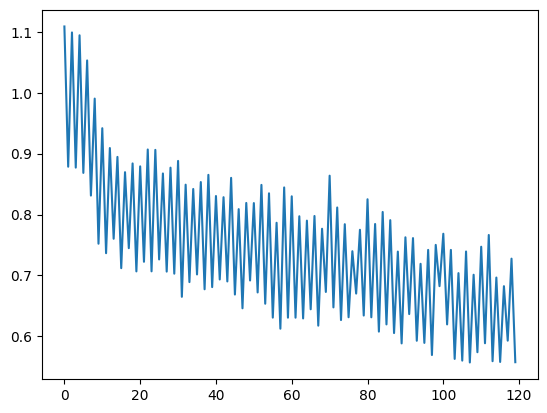

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='train')
range(len(train_losses))

In [ ]:
accuracies = [acc.item() for acc in accuracies]

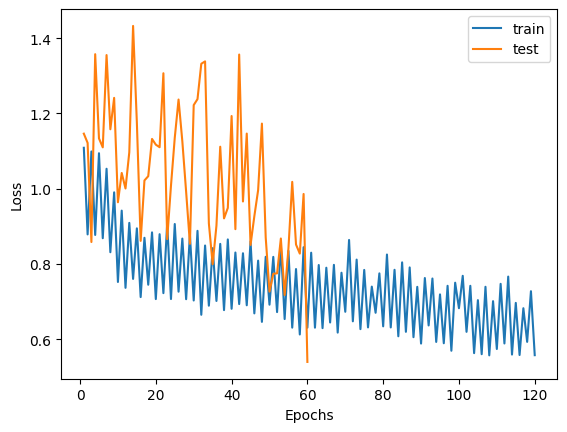

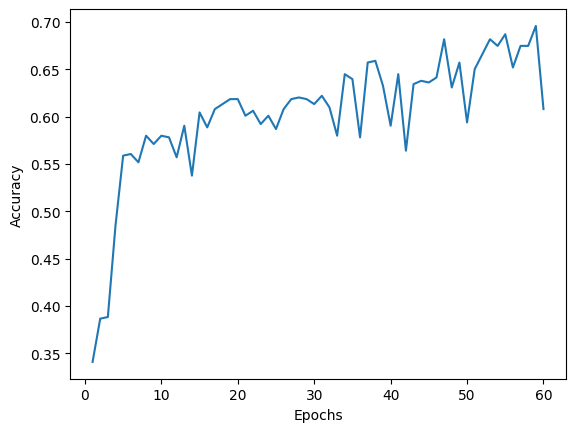

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
plt.plot(range(1, len(test_losses)  + 1), test_losses, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1, len(accuracies) + 1), accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
